<a href="https://colab.research.google.com/github/lucapqg/Deep-learning/blob/main/reinforcement_learning_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas_datareader.data as web
from collections import deque
import random
import tensorflow.compat.v1 as tf
import datetime as dt
tf.compat.v1.disable_eager_execution()

In [ ]:
ticker = 'INFY'
start = dt.datetime(2011, 1, 1)
end = dt.datetime(2021, 1, 24)
df_full = web.DataReader(ticker, 'yahoo', start=start, end=end).reset_index()
# data.reset_index(inplace=True)
# ibov['DateAsNumber'] = ibov.Date.map(mdates.date2num)
df_full.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2011-01-03,9.74000,9.60125,9.61000,9.69125,5504800.0,7.415166
1,2011-01-04,9.69000,9.51500,9.66750,9.61000,5237600.0,7.352998
2,2011-01-05,9.73125,9.53625,9.65125,9.67250,7841600.0,7.400818
3,2011-01-06,9.70750,9.60500,9.62125,9.66125,5569600.0,7.392210
4,2011-01-07,9.52125,9.37750,9.49250,9.47000,13986400.0,7.245876


In [ ]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.keras.layers.Dense( 256, activation = 'relu')(self.X)
        self.logits = tf.keras.layers.Dense(self.action_size)(feed)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
%%time
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 4.248741.3, cost: 0.005419, total money: 10004.248741
epoch: 20, total rewards: -1.130008.3, cost: 0.006722, total money: 9998.869992
epoch: 30, total rewards: 2.096242.3, cost: 0.005308, total money: 10002.096242
epoch: 40, total rewards: 2.212488.3, cost: 0.005466, total money: 10002.212488
epoch: 50, total rewards: 2.307488.3, cost: 0.005858, total money: 10002.307488
epoch: 60, total rewards: 5.118737.3, cost: 0.005565, total money: 10005.118737
epoch: 70, total rewards: 0.559990.3, cost: 0.005735, total money: 10000.559990
epoch: 80, total rewards: 6.763737.3, cost: 0.005694, total money: 10006.763737
epoch: 90, total rewards: 3.108735.3, cost: 0.005644, total money: 10003.108735
epoch: 100, total rewards: 6.804984.3, cost: 0.005586, total money: 10006.804984
epoch: 110, total rewards: 3.832486.3, cost: 0.005547, total money: 10003.832486
epoch: 120, total rewards: 7.322486.3, cost: 0.005494, total money: 10007.322486
epoch: 130, total rewards: 3.283736.3

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 9.691250, total balance 9990.308750
day 1, sell 1 unit at price 9.610000, investment -0.838387 %, total balance 9999.918750,
day 2: buy 1 unit at price 9.672500, total balance 9990.246250
day 3, sell 1 unit at price 9.661250, investment -0.116304 %, total balance 9999.907500,
day 5: buy 1 unit at price 9.405000, total balance 9990.502501
day 7: buy 1 unit at price 9.585000, total balance 9980.917500
day 8, sell 1 unit at price 8.980000, investment -4.518875 %, total balance 9989.897500,
day 11, sell 1 unit at price 8.856250, investment -7.603028 %, total balance 9998.753750,
day 12: buy 1 unit at price 8.833750, total balance 9989.920000
day 13, sell 1 unit at price 8.786250, investment -0.537707 %, total balance 9998.706250,
day 16: buy 1 unit at price 8.801250, total balance 9989.905000
day 17: buy 1 unit at price 8.757500, total balance 9981.147500
day 19, sell 1 unit at price 8.463750, investment -3.834689 %, total balance 9989.611250,
day 20, sell 1 unit

In [ ]:
total_gains

4.47873592376709

In [ ]:
invest

0.044787359237670896

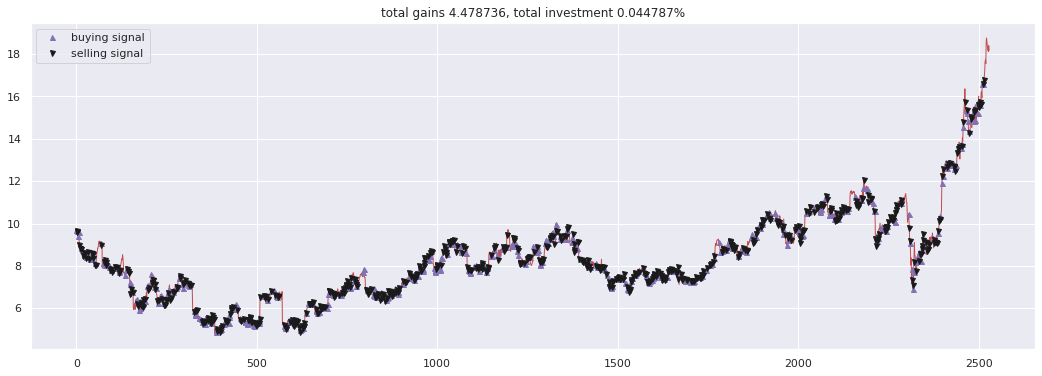

In [ ]:
fig = plt.figure(figsize = (18,6))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=5, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=5, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()